# Dealing with Missingness

The goal of the exercise is to get comfortable with different types of missingness and ways to try and handle them with a few basic imputations methods using numpy, pandas, and sklearn. The examples will show how the combination of different types of missingness and imputation methods can affect inference.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression 
from sklearn.impute import SimpleImputer, KNNImputer

Dealing with Missingness

In [2]:
# Number of data points to generate
n = 500
# Set random seed for numpy to ensure reproducible results
np.random.seed(109)
# Generate our predictors...
x1 = np.random.normal(0, 1, size=n)
x2 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])
# Generate our response...
y = 3*x1 - 2*x2 + np.random.normal(0, 1, size=n)
y = pd.Series(y)
# And put them all in a nice DataFrame
df = pd.DataFrame(data=np.transpose([x1, x2, y]), columns=["x1", "x2", "y"]) 

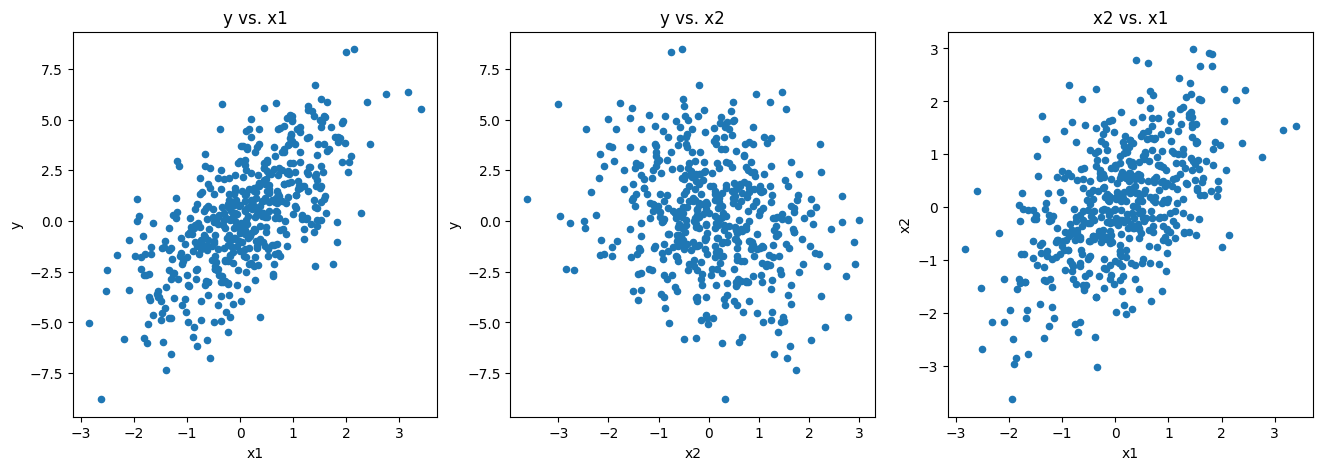

In [3]:
fig, axs =  plt.subplots(1, 3, figsize = (16,5))

plot_pairs = [('x1', 'y'), ('x2', 'y'), ('x1', 'x2')]
for ax, (x_var, y_var) in zip(axs, plot_pairs):
    df.plot.scatter(x_var, y_var, ax=ax, title=f'{y_var} vs. {x_var}')

- Poke holes in X_1 different ways:
    - Missing Completely at Random (MCAR): missingness is not predictable.
    - Missing at Random (MAR): missingness depends on other observed data, and thus can be recovered in some way
    - Missingness not at Random (MNAR): missingness depends on unobserved data and thus cannot be recovered

Here we generate indices of X_1 to be dropped due to 3 types of missingness using n single bernoulli trials.
The only difference between the 3 sets of indices is the probabilities of success for each trial (i.e., the probability that a given observation will be missing).

In [4]:
missing_A = np.random.binomial(1, 0.05 + 0.85*(y > (y.mean()+y.std())),  n).astype(bool)
missing_B = np.random.binomial(1, 0.2, n).astype(bool)
missing_C = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())), n).astype(bool)

In [5]:
# Helper function to replace x_1 with nan at specified indices
def create_missing(missing_indices, df=df):
    df_new = df.copy()
    df_new.loc[missing_indices, 'x1'] = np.nan
    return df_new

Fill in the blanks below by matching the index sets above (missing_A, missing_B, or missing_C) to the type of missingness they represent.

In [6]:
### edTest(test_missing_type) ###

# Missing completely at random (MCAR)
df_mcar = create_missing(missing_indices=missing_B)

# Missing at random (MAR)
df_mar = create_missing(missing_indices=missing_C)

# Missing not at random (MNAR)
df_mnar = create_missing(missing_indices=missing_A)

First, let's fit a model with no missing data.

In [7]:
# no missingness: on the full dataset
ols = LinearRegression().fit(df[['x1', 'x2']], df['y'])
print('No missing data:', ols.intercept_, ols.coef_)

No missing data: 0.10204379528391672 [ 2.92281015 -1.93658251]


 Take a moment to consider your so far. * Why aren't the estimates exactly \bar(\beta)_0 = 0, \.\beta_1 = 3, \.\beta 2 = -2?
​
Isn't that our true data generating function?


Now, let's naively fit a linear regression on the dataset with MCAR missingness and see what happens...

In [8]:
# Fit inside a try/except block just in case...
try:
    ouch = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
except Exception as e:
    print(e)

Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


How did sklearn handle the missingness? (feel free to add some code above to experiment if you are still unsure)

A: It ignored the columns with missing values
B: It ignored the rows with missing values
C: It didn't handle the missingness and the fit failed

--C

What happens if we ignore problematic rows?

In [9]:
# MCAR: drop the rows that have any missingness
ols_mcar = LinearRegression().fit(df_mcar.dropna()[['x1', 'x2']], df_mcar.dropna()['y'])
print('MCAR (drop):', ols_mcar.intercept_, ols_mcar.coef_)

MCAR (drop): 0.09607569437217311 [ 2.95778269 -1.90922895]


Use the same strategy for the other types of missingness.

In [10]:
### edTest(test_mar) ###
# MAR: drop the rows that have any missingness
ols_mar = LinearRegression().fit(df_mar.dropna()[['x1', 'x2']], df_mar.dropna()['y'])
print('MAR (drop):', ols_mar.intercept_,ols_mar.coef_)

MAR (drop): 0.14606481117880465 [ 2.93256228 -1.89351279]


In [11]:
# MNAR: drop the rows that have any missingness
ols_mnar = LinearRegression().fit(df_mnar.dropna()[['x1', 'x2']], df_mnar.dropna()['y'])
print('MNAR (drop):', ols_mnar.intercept_, ols_mnar.coef_)

MNAR (drop): 0.020221283325560835 [ 2.77095031 -1.84859735]


Compare the various estimates above and how well they were able to recover the true value of \beta_1 which was 3. For which form of missingness did dropping result in the worst estimate?
A: MCAR
B: MAR
C: MNAR

--C

Let's Start Imputing

In [12]:
# Make backup copies for later since we'll have lots of imputation approaches.
X_mcar_raw = df_mcar.drop('y', axis=1).copy()
X_mar_raw = df_mar.drop('y', axis=1).copy()
X_mnar_raw = df_mnar.drop('y', axis=1).copy()

Mean Imputation:
Perform mean imputation using the fillna, dropna, and mean functions.

In [13]:
# Here's an example of one way to do the mean imputation with the above methods
X_mcar = X_mcar_raw.copy()
X_mcar['x1'] = X_mcar['x1'].fillna(X_mcar['x1'].mean())
# Another approach
# df = df.fillna(df.mean)
# This will replace all nans in a df with each column's mean

ols_mcar_mean = LinearRegression().fit(X_mcar, y)
print('MCAR (mean):', ols_mcar_mean.intercept_, ols_mcar_mean.coef_)

MCAR (mean): 0.06518722125657428 [ 2.76751051 -1.56434888]


In [14]:
### edTest(test_mar_mean) ###
X_mar = X_mar_raw.copy()

X_mar['x1'] = X_mar['x1'].fillna(X_mar['x1'].mean())
# You can add as many lines as you see fit, so long as the final model is correct
ols_mar_mean = LinearRegression().fit(X_mar, y)
print('MAR (mean):',ols_mar_mean.intercept_, ols_mar_mean.coef_)

MAR (mean): 0.3922738786668912 [ 2.62546455 -1.22434111]


We can also use SKLearn's SimpleImputer object. By default it will replace NaN values with the column's mean.

In [15]:
### edTest(test_mnar_mean) ###
X_mnar = X_mnar_raw.copy()
# instantiate imputer object
imputer = SimpleImputer()
# fit & transform X_mnar with the imputer
X_mnar = imputer.fit_transform(X_mnar)
# fit OLS model on imputed data
ols_mnar_mean = LinearRegression().fit(X_mnar, y)
print('MNAR (mean):', ols_mnar_mean.intercept_, ols_mnar_mean.coef_)

MNAR (mean): 0.520706160894387 [ 2.64232555 -1.67075578]


In our examples, how do these estimates compare when performing mean imputation vs. just dropping rows?

A: They are better
B: They are worse
C: They are the same

--B

### Linear Regression Imputation 

If you're not careful, it can be difficult to keep things straight.  There are _two_ models here: 

1. an _imputation_ model concerning just the predictors (to predict $X_1$ from $X_2$) and 
2. the _substantive_ model we really care about used to predict $Y$ from the 'improved' $X_1$ (now with imputed values) and $X_2$.

In [16]:
X_mcar = X_mcar_raw.copy()

# Fit the imputation model
ols_imputer_mcar = LinearRegression().fit(X_mcar.dropna()[['x2']], X_mcar.dropna()['x1'])

# Perform some imputations
x1hat_impute = pd.Series(ols_imputer_mcar.predict(X_mcar[['x2']]))
X_mcar['x1'] = X_mcar['x1'].fillna(x1hat_impute)

# Fit the model we care about
ols_mcar_ols = LinearRegression().fit(X_mcar, y)
print('MCAR (OLS):', ols_mcar_ols.intercept_,ols_mcar_ols.coef_)

MCAR (OLS): 0.11835122909536355 [ 2.95778269 -1.91346654]


In [17]:
### edTest(test_mar_ols) ###
X_mar = X_mar_raw.copy()
# Fit imputation model
ols_imputer_mar = LinearRegression().fit(X_mar.dropna()[['x2']], X_mar.dropna()['x1'])
# Get values to be imputed
x1hat_impute = pd.Series(ols_imputer_mar.predict(X_mar[['x2']]))
# Fill missing values with imputer's predictions
X_mar['x1'] = X_mar['x1'].fillna(x1hat_impute)
# Fit our final, 'substantive' model
ols_mar_ols = LinearRegression().fit(X_mar, y)

print('MAR (OLS):', ols_mar_ols.intercept_,ols_mar_ols.coef_)

MAR (OLS): 0.007334836526979582 [ 2.93256228 -1.99438598]


In [18]:
### edTest(test_mnar_ols) ###
X_mnar = X_mnar_raw.copy()

ols_imputer_mnar = LinearRegression().fit(X_mnar.dropna()[['x2']], X_mnar.dropna()['x1'])
# Get values to be imputed
x1hat_impute = pd.Series(ols_imputer_mnar.predict(X_mnar[['x2']]))
# Fill missing values with imputer's predictions
X_mnar['x1'] = X_mnar['x1'].fillna(x1hat_impute)
# You can add as many lines as you see fit, so long as the final model is correct
ols_mnar_ols = LinearRegression().fit(X_mnar, y)
print('MNAR (OLS):', ols_mnar_ols.intercept_, ols_mnar_ols.coef_)

MNAR (OLS): 0.6148065869266275 [ 2.77095031 -1.97302957]


⏸️ **Q4**: Compare the estimates when performing OLS model-based imputation vs. mean imputation?  Which type of missingness saw the biggest improvement?

**A**: MCAR\
**B**: MAR\
**C**: MNAR

--B

### $k$-NN Imputation ($k$=3)
As an alternative to linear regression, we can also use $k$-NN as our imputation model.\
SKLearn's `KNNImputer` object makes this very easy.

In [19]:
X_mcar = X_mcar_raw.copy()

X_mcar = KNNImputer(n_neighbors=3).fit_transform(X_mcar)

ols_mcar_knn = LinearRegression().fit(X_mcar,y)

print('MCAR (KNN):', ols_mcar_knn.intercept_,ols_mcar_knn.coef_)

MCAR (KNN): 0.15134915515799063 [ 2.78459666 -1.85426345]


In [20]:
### edTest(test_mar_knn) ###
X_mar = X_mar_raw.copy()
# Add imputed values to X_mar
X_mar = KNNImputer(n_neighbors=3).fit_transform(X_mar)
# Fit substantive model on imputed data
ols_mar_knn = LinearRegression().fit(X_mar,y)

print('MAR (KNN):', ols_mar_knn.intercept_,ols_mar_knn.coef_)

MAR (KNN): 0.24560978941317946 [ 2.72661518 -1.55667191]


In [21]:
### edTest(test_mnar_knn) ###
X_mnar = X_mnar_raw.copy()
# Add imputed values to X_mar
X_mnar = KNNImputer(n_neighbors=3).fit_transform(X_mnar)
# You can add as many lines as you see fit, so long as the final model is correct
ols_mnar_knn = LinearRegression().fit(X_mnar,y)

print('MNAR (KNN):', ols_mnar_knn.intercept_,ols_mnar_knn.coef_)

MNAR (KNN): 0.6358511234519549 [ 2.62065071 -1.93067768]


⏸️ **Q5**: True or False - While some methods may work better than others depending on the context, any imputation method is always better than none (that is, as opposed to simply dropping).

--False

In [22]:
### edTest(test_Q5) ###
# Submit an answer choice as boolean value
answer5 = False

⏸️ **Q6**: Suppose your friends makes the following suggestion:

"The MNAR missing data can be predicted in part from the response $y$. Why not impute these missing $x_1$ values with an imputation model using $y$ as a predictor? It's true we can't impute like this with new data for which we don't have the $y$ values. But it will improve our training data, our model's fit, and so too its performance on new data!"

What is a _big problem_ with this idea?

---never use response value as predictor